## Nhận dạng ký tự trong biển xe bằng CNN

In [1]:
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


### Đọc dữ liệu từ tập dataset
Thư mục character_dataset
Sử dụng lớp ImageDataGenerator:
- rescale: giảm giá trị dữ liệu (ảnh RGB [0,255]) về [0,1] để xử lý dễ dàng.
- width_shift_range, height_shift_range được sử dụng để tạo thêm dữ liệu cho bộ huấn luyện. Giá trị float: ảnh được dịch sang trái/phải (width) hoặc lên/xuống (height) một khoảng gia_tri_float*kich_thuoc_anh.
- resize các ảnh về 28x28.

In [2]:
dataset = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1)

path = 'character_dataset'

train = dataset.flow_from_directory(
    path+'/train',  # đường dẫn thư mục
    target_size=(28, 28),  # resize các ảnh về 28x28
    batch_size=1,  # kích thước lô dữ liệu
    class_mode='categorical')

validation = dataset.flow_from_directory(
    path+'/val',
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical')


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


### Khởi tạo mô hình CNN
Mô hình sẽ gồm các layers:
- 2 convolutional nối tiếp, mỗi lớp tích chập có 32 nơ-ron kích thước (3x3) với hàm kích hoạt là 'relu', padding là 'same'.
- MaxPooling với kích thước cửa số (2x2), giúp giảm kích thước khối dữ liệu để giảm bộ nhớ và khối lượng tính toán nhưng vẫn giữ được các đặc trưng được trích xuất từ lớp tích chập.
- tiếp theo là 2 convolutional nối tiếp, mỗi lớp tích chập có 64 nơ-ron kích thước (3x3) với hàm kích hoạt là 'relu', padding là 'same'.
- MaxPooling với kích thước cửa số (2x2).
- Dropout: loại bỏ một số tỷ lệ bỏ học để tránh overfitting. Dropout là một siêu thông số chính quy được khởi tạo để ngăn Neural Network bị overfitting. Chọn dropout=0,4 có nghĩa là 60% nút sẽ được giữ lại.
- Flatten: lớp làm phẳng dữ liệu nút. Lớp làm phẳng lấy dữ liệu từ lớp trước và thể hiện nó trong một chiều duy nhất.
- 2 lớp fully connected: 2 lớp Dense output ra 36 nhãn (26 chữ cái + 10 chữ số) với hàm kích hoạt ở lớp cuối cùng là 'softmax' (do là bài toán phân loại nhiều lớp)

Các tham số sử dụng:
- dropout rate: 0.4
- learning rate: 0.0001
- trình tối ưu optimizer: adam
- loss function: categorical_crossentropy

In [3]:
K.clear_session()
model = Sequential() # tạo 1 lớp tuần tự
model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [4]:
# tóm tắt cấu trúc mạng
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
__________

# Huấn luyện mô hình

``` batch_size = 1 ``` và ``` step_per_epoch = train.samples // batch_size ``` để đảm bảo sẽ sử dụng tất cả dữ liệu tập train trong 1 epoch

In [5]:
mc = ModelCheckpoint('weights/model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

batch_size = 1
result = model.fit_generator(
    train,
    steps_per_epoch=train.samples // batch_size,
    validation_data=validation,
    validation_steps=validation.samples // batch_size,
    epochs=30, verbose=1, callbacks=[mc])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
864/864 [==============================] - 21s 24ms/step - loss: 3.0600 - acc: 0.1933 - val_loss: 1.5528 - val_acc: 0.5648

Epoch 00001: val_acc improved from -inf to 0.56481, saving model to weights/model.h5
Epoch 2/30
864/864 [==============================] - 11s 13ms/step - loss: 1.1489 - acc: 0.6458 - val_loss: 0.7093 - val_acc: 0.8194

Epoch 00002: val_acc improved from 0.56481 to 0.81944, saving model to weights/model.h5
Epoch 3/30
864/864 [==============================] - 11s 13ms/step - loss: 0.6668 - acc: 0.7928 - val_loss: 0.3745 - val_acc: 0.8611

Epoch 00003: val_acc improved from 0.81944 to 0.86111, saving model to weights/model.h5
Epoch 4/30
864/864 [==============================] - 12s 13ms/step - loss: 0.4186 - acc: 0.8600 - val_loss: 0.1785 - val_acc: 0.9259

Epoch 00004: val_acc improved from 0.86111 to 0.92593, saving model to weights/model.h5
Epoch 5/30
864/86

### Vẽ đồ thị kết quả quá trình training

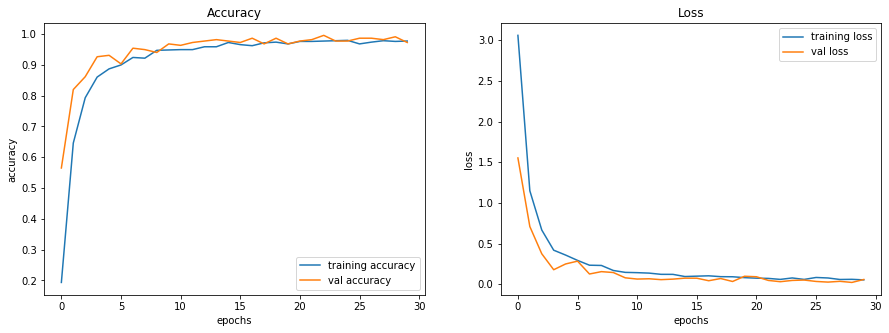

In [6]:
# Vẽ đồ thị kết quả training
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
grid = GridSpec(ncols=2, nrows=1, figure=fig)

fig.add_subplot(grid[0])
plt.plot(result.history['acc'], label='training accuracy')
plt.plot(result.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


### Thử nghiệm các mô hình khác
Thử nghiệm thay đổi các lớp tích chập với kích thước khác nhau

In [7]:
"""
Sử dụng model 2
"""

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ModelCheckpoint

dataset = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1)

path = 'character_dataset'

train = dataset.flow_from_directory(
    path+'/train',  # đường dẫn thư mục
    target_size=(28, 28),  # resize các ảnh về 28x28
    batch_size=1,  # kích thước lô dữ liệu
    class_mode='categorical')

validation = dataset.flow_from_directory(
    path+'/val',
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical')

K.clear_session()
model = Sequential() # tạo 1 lớp tuần tự
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

model.summary()

mc = ModelCheckpoint('weights/model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________________________________________________________

Epoch 1/30
864/864 [==============================] - 12s 14ms/step - loss: 3.0643 - acc: 0.1991 - val_loss: 1.7604 - val_acc: 0.5278

Epoch 00001: val_acc improved from -inf to 0.52778, saving model to weights/model2.h5
Epoch 2/30
864/864 [==============================] - 11s 13ms/step - loss: 1.1993 - acc: 0.6377 - val_loss: 0.5546 - val_acc: 0.8333

Epoch 00002: val_acc improved from 0.52778 to 0.83333, saving model to weights/model2.h5
Epoch 3/30
864/864 [==============================] - 13s 15ms/step - loss: 0.6462 - acc: 0.8044 - val_loss: 0.3677 - val_acc: 0.8889

Epoch 00003: val_acc improved from 0.83333 to 0.88889, saving model to weights/model2.h5
Epoch 4/30
864/864 [==============================] - 12s 14ms/step - loss: 0.4368 - acc: 0.8553 - val_loss: 0.2961 - val_acc: 0.9028

Epoch 00004: val_acc improved from 0.88889 to 0.90278, saving model to weights/model2.h5
Epoch 5/30
864/864 [==============================] - 11s 12ms/step - loss: 0.3256 - acc: 0.9016 - val_loss

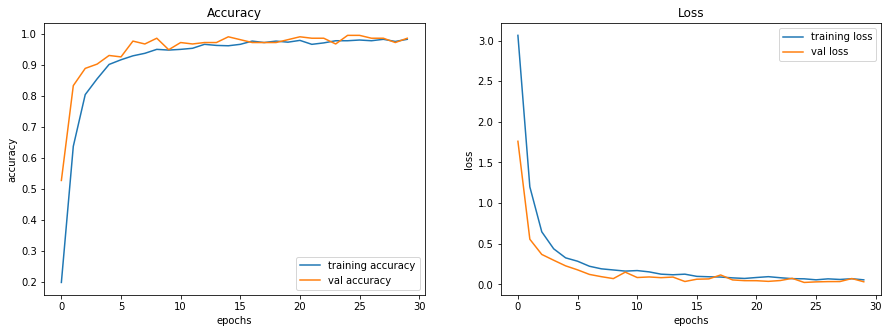

In [8]:
batch_size = 1
result = model.fit_generator(
      train,
      steps_per_epoch = train.samples // batch_size,
      validation_data = validation, 
      validation_steps = validation.samples // batch_size,
      epochs = 30, callbacks=[mc])

# Vẽ đồ thị kết quả training
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
grid = GridSpec(ncols=2, nrows=1, figure=fig)

fig.add_subplot(grid[0])
plt.plot(result.history['acc'], label='training accuracy')
plt.plot(result.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()